In [2]:
import time
import math

import numpy as np
import pandas as pd
from itertools import product
from Database.services.database import Database
from sqlalchemy import inspect
from services.data_retreival import *
from scipy.stats import gmean
import matplotlib.pyplot as plt
from services.strategies import *
from services.optimization_layers import *
from services.optimization import *
from services.binary_optimization import *
from services.environment_functions import *
from services.big_m_strategies import *
from services.experiments import *
from services.plotting_functions import *

Database.initialize("sqlite:///Database//financial_db.sqlite") #for courses replace this with a flat file
inspector = inspect(Database.engine)
print(inspector.get_table_names())

universe = 'ETF'
imputation_method = 'Univariate'
ticker_str = 'SPY'
#exponential params


adjClose = pd.read_csv("flat_files/MonthlyAssetPrices"+ universe + ".csv", index_col=0, header = 1).iloc[1:,:]

daily_adjClose =  pd.read_csv("flat_files/DailyAssetPrices"+universe + ".csv", index_col=0, header = 1).iloc[1:,:]

TechnicalAnalysis = pd.read_csv("flat_files/TechnicalAnalysis" + universe + ".csv", index_col=[0,1])

if universe ==  'SP':
    FinancialRatios = pd.read_csv("flat_files/" + imputation_method + "WRDS.csv", index_col=[0,1])
    TechnicalAnalysis.index.names = FinancialRatios.index.names
    ContextualInfo = TechnicalAnalysis.merge(FinancialRatios, how = 'left', left_index=True, right_index=True)

else:
    TechnicalAnalysis.index.names = ['date', 'ticker']
    ContextualInfo = TechnicalAnalysis


['asset_id', 'currency_id', 'equities_series', 'equity_index_id', 'exchange_id', 'factor_id', 'factors', 'frequency_id', 'fundamentals', 'metric_id', 'source_id', 'ticker_id', 'ticker_index_membership', 'tiingo_tickers']


In [3]:
adjClose.index = pd.to_datetime(adjClose.index, format='%Y-%m-%d').tz_localize(None)
daily_adjClose.index = pd.to_datetime(daily_adjClose.index, format='%Y-%m-%d').tz_localize(None)
ContextualInfo.index = ContextualInfo.index.set_levels([pd.to_datetime(ContextualInfo.index.levels[0]).tz_localize(None), ContextualInfo.index.levels[1]])

In [4]:
print("The earliest possible start date")
max(daily_adjClose.index.unique()[0], ContextualInfo.index.get_level_values('date').unique()[0], adjClose.index.unique()[0])

The earliest possible start date


Timestamp('2006-01-31 00:00:00')

In [5]:
print("The latest possible start date")
min(daily_adjClose.index.unique()[-1], ContextualInfo.index.get_level_values('date').unique()[-1], adjClose.index.unique()[-1])

The latest possible start date


Timestamp('2023-04-21 00:00:00')

In [6]:
# start_date = pd.to_datetime('1996-11-30', format = '%Y-%m-%d')
# 
# end_date = pd.to_datetime('2022-12-31', format = '%Y-%m-%d')

start_date = pd.to_datetime('2006-05-31', format = '%Y-%m-%d')

end_date = pd.to_datetime('2022-12-31', format = '%Y-%m-%d')

factors = ('Mkt-RF', 'RF')

factorRet = get_monthly_factors(factors, start_date, end_date, Database)

factorRet = factorRet.droplevel(0, axis = 1)
factorRet.columns = [col.strip() for col in factorRet.columns]

In [7]:
adjClose = adjClose[start_date:end_date]
daily_adjClose = daily_adjClose[start_date:end_date]
idx = pd.IndexSlice
ContextualInfo = ContextualInfo.loc[idx[start_date:end_date, :], :]

In [8]:
# divide the factor returns by 100
factorRet = factorRet/100

#rf and factor returns
#drop the first observation to align the dataset with the returns data that will
#result
factorRet = factorRet.iloc[1:, :]

#rf and factor returns
riskFree = factorRet['RF']
factorRet = factorRet.loc[:,factorRet.columns != 'RF'];

In [9]:
#Identify the tickers and the dates
tickers = adjClose.columns
dates   = factorRet.index

In [10]:
# Calculate the stocks monthly excess returns
# pct change and drop the first null observation
returns = adjClose.pct_change(1).iloc[1:, :]
returns = returns  - np.diag(riskFree.values) @ np.ones_like(returns.values) # risk adjusted returns
# Align the price table to the asset and factor returns tables by discarding the first observation.
adjClose = adjClose.iloc[1:,:]

In [11]:
assert adjClose.index[0] == returns.index[0]
assert adjClose.index[0] == factorRet.index[0]

# Experimental Analysis

In [184]:
# Some strategies (uncomment this or the next cell to pick a strategy to test)
# Strategy = general_strategy(sample_estimator, MVO, NumObs=48)  #the general strategy object takes an estimator function and an optimizer function
#                                                                #the only constraint is that the estimators outputs are the optimizers inputs
# investor preferences (static throughout the backtest)
initialVal = 100000
CardMVOrun = 'Sat3Jan132024' #'SatJan132024'
SVMMVOrun = 'MonJan152024'
qs = [2]

In [185]:
CardMVO_path = "Experiments//"+universe+"//"+"CardMVO"
CardMVO_experiments = pd.read_pickle(CardMVO_path+"//data_dictionary.pkl")
CardMVO_experiments = CardMVO_experiments[CardMVO_experiments.run == CardMVOrun]
CardMVO_experiments

,uid,estimator,optimizer,universe,imputation_method,ticker_str,hyperparam_search,NoPeriods,C,LogToConsole,...,q,q_alpha,separable,target_return_strategy,target_return_strategy_args,ticker_index,tightening_iter_lim,turnover_constraints,turnover_limit,run
9aee50b204cd696aa8118f7eabcaa2e0c9bc71ea,9aee50b204cd696aa8118f7eabcaa2e0c9bc71ea,exponential_weighted_estimator,CardMVO,ETF,Univariate,SPY,False,29,0.01,False,...,3,0.3187,False,premium_target,['premium'],250,1,True,0.75,Sat3Jan132024
cc5e0f746b379ee718b1c8c3ce64f31807d5233f,cc5e0f746b379ee718b1c8c3ce64f31807d5233f,exponential_weighted_estimator,CardMVO,ETF,Univariate,SPY,False,29,0.01,False,...,3,0.3187,False,premium_target,['premium'],250,1,True,1,Sat3Jan132024
092888b2b25048092d5351ecd5e3ee99c19f1df5,092888b2b25048092d5351ecd5e3ee99c19f1df5,exponential_weighted_estimator,CardMVO,ETF,Univariate,SPY,False,29,0.01,False,...,3,0.3187,False,premium_target,['premium'],250,1,True,1.25,Sat3Jan132024
e96467e8f6197c54ccaee9916b80d7a3e445c7ef,e96467e8f6197c54ccaee9916b80d7a3e445c7ef,exponential_weighted_estimator,CardMVO,ETF,Univariate,SPY,False,29,0.01,False,...,3,0.3187,False,premium_target,['premium'],250,1,True,0.75,Sat3Jan132024
0908a777cccf4309b33fe96742ed7e4dd8acca64,0908a777cccf4309b33fe96742ed7e4dd8acca64,exponential_weighted_estimator,CardMVO,ETF,Univariate,SPY,False,29,0.01,False,...,3,0.3187,False,premium_target,['premium'],250,1,True,1,Sat3Jan132024
f5745a31dd7c7f29ab91210ef191cead5758216b,f5745a31dd7c7f29ab91210ef191cead5758216b,exponential_weighted_estimator,CardMVO,ETF,Univariate,SPY,False,29,0.01,False,...,3,0.3187,False,premium_target,['premium'],250,1,True,1.25,Sat3Jan132024
cbea9d063ea6a329ca7e89dd20f149a725b249a0,cbea9d063ea6a329ca7e89dd20f149a725b249a0,exponential_weighted_estimator,CardMVO,ETF,Univariate,SPY,False,29,0.01,False,...,3,0.3187,False,premium_target,['premium'],250,1,True,0.75,Sat3Jan132024
1f50a780394ba72d4c3c43183e7a4f28fe7a8444,1f50a780394ba72d4c3c43183e7a4f28fe7a8444,exponential_weighted_estimator,CardMVO,ETF,Univariate,SPY,False,29,0.01,False,...,3,0.3187,False,premium_target,['premium'],250,1,True,1,Sat3Jan132024
39f204ab23afd7b68c8390526d39a4924db6e05c,39f204ab23afd7b68c8390526d39a4924db6e05c,exponential_weighted_estimator,CardMVO,ETF,Univariate,SPY,False,29,0.01,False,...,3,0.3187,False,premium_target,['premium'],250,1,True,1.25,Sat3Jan132024
5d42e8b4dff8e3af7735ad1348a9e2acbf8471d3,5d42e8b4dff8e3af7735ad1348a9e2acbf8471d3,exponential_weighted_estimator,CardMVO,ETF,Univariate,SPY,False,29,0.01,False,...,3,0.3187,False,premium_target,['premium'],250,1,True,0.75,Sat3Jan132024


In [186]:
assert (CardMVO_experiments.groupby(['cardinality_ratio', 'turnover_limit']).uid.count() == 1).all()

In [187]:
unique_card_turnover_df = CardMVO_experiments.groupby(['cardinality_ratio', 'turnover_limit']).uid.first()

In [189]:
SVMMVO_experiments_q

,uid,estimator,optimizer,universe,imputation_method,ticker_str,hyperparam_search,NoPeriods,run,C,...,premium,q,q_alpha,separable,target_return_strategy,target_return_strategy_args,ticker_index,tightening_iter_lim,turnover_constraints,turnover_limit


In [188]:
SVMMVO_experiments = {}
for q in qs:
    SVMMVO_path_q = "Experiments//"+universe+"//"+"SVMMVO"+"//"+str(q)
    SVMMVO_experiments_q = pd.read_pickle(SVMMVO_path_q+"//data_dictionary.pkl")
    SVMMVO_experiments_q =SVMMVO_experiments[SVMMVO_experiments_q.run == SVMMVOrun]
    assert (SVMMVO_experiments_q.groupby(['cardinality_ratio', 'turnover_limit']).uid.count() == 1).all()
    SVMMVO_experiments[q] = SVMMVO_experiments_q

TypeError: unhashable type: 'Series'

In [18]:
#def read_results(CardMVO_experiments):
CardMVO_results = {}
MVO_results = {}

for i in unique_card_turnover_df.index:
    CardMVO_results[i] = import_experimental_results(CardMVO_path, unique_card_turnover_df[i])
    if float(i[0]) > 0.99: # no restrictions on cardinality
        MVO_results[i[1]] = import_experimental_results(CardMVO_path, unique_card_turnover_df[i]) #MVO dict is a function of turnover

In [106]:
def plot_results_relative_ticker(CardMVO_results, MVO_results, turnovers, cardinalities, card_strings,
                                 turnover_strings, adjClose, initialVal=100000, ticker_str='SPY', figsize=(8.5, 10.5)):
    max_y = 0
    lw = 1
    min_y = 0.8

    fig, axs = plt.subplots(len(cardinalities), len(turnovers),
                            sharex=True, sharey=True, figsize=figsize)

    if len(cardinalities) == 1:
        axs = np.expand_dims(axs, axis=0)
    if len(turnovers) == 1:
        axs = np.expand_dims(axs, axis=1)

    df_cols = []
    # load in the appropriate files
    for i in range(len(cardinalities)):

        df_rows = []

        for j in range(len(turnovers)):
            turnover_lim = turnovers[j]
            card = cardinalities[i]
            card_mvo_wealth, elapsed_time, x, turnover = CardMVO_results[(str(card), str(turnover_lim))]
            if ticker_str is not None:
                value_target_index = adjClose.loc[card_mvo_wealth.index, ticker_str]
                time0 = value_target_index.index[0] - pd.offsets.MonthEnd(1)
                spy_time0 = adjClose.loc[time0, ticker_str]
                value_target_index = initialVal * value_target_index / spy_time0

            card_mvo_wealth.columns = ['Card-MVO']

            mvo_wealth, elapsed_time, x, turnover = MVO_results[str(turnover_lim)]
            mvo_wealth.columns = ['MVO']

            card_mvo_rel_wealth = pd.Series(card_mvo_wealth.values.flatten() / value_target_index.values.flatten(),
                                            index=card_mvo_wealth.index)
            mvo_wealth_rel_wealth = pd.Series(mvo_wealth.values.flatten() / value_target_index.values.flatten(),
                                              index=mvo_wealth.index)
            card_mvo_rel_wealth.plot(fontsize=8, ax=axs[i, j], linewidth=lw, legend=False, label='Card-MVO')
            mvo_wealth_rel_wealth.plot(fontsize=8, ax=axs[i, j], linewidth=lw, legend=False, label='MVO')

            # if ticker_str is not None:
            # value_target_index.plot(fontsize = 8, ax=axs[i, j], linewidth = lw, legend = False)

            card_string = card_strings[i]
            turnover_string = turnover_strings[j]

            axs[i, j].set_title(card_string + ", " + turnover_string, fontsize=8)
            # print(card_mvo_wealth.max()[0])
            max_ = card_mvo_rel_wealth.max()  # [0]
            # print(max_)
            if max_ > max_y:
                max_y = max_

    axs[len(cardinalities) - 1, 0].legend(loc='upper center',
                                          bbox_to_anchor=(0.5, -0.4),
                                          fancybox=False,
                                          shadow=False, ncol=3,
                                          fontsize=8)
    for ax in axs:
        for sub_ax in ax:
            sub_ax.yaxis.set_tick_params(which='minor', bottom=False)
            sub_ax.set_yticks([min_y + i * 0.2 for i in range(2 + int((max_y - min_y) / 0.2))])
            sub_ax.grid()
            sub_ax.set_xlabel("Date", fontsize=8)
    # fig.supxlabel('Date',fontsize = 8)
    fig.supylabel("Cumulative Relative Wealth", fontsize=8)
    # plt.tight_layout()
    fig.subplots_adjust(wspace=0.05, hspace=0.4)

    return

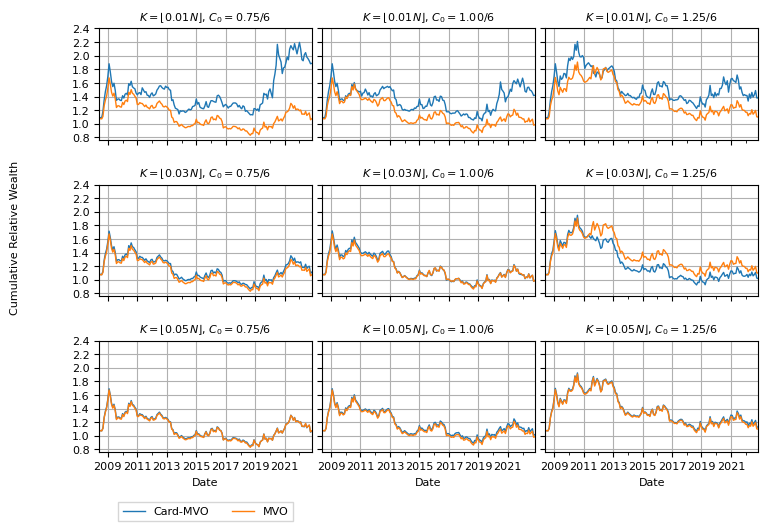

In [107]:
cardinality_ratios = [0.01, 0.03, 0.05] # includes mvo
turnover_limits = [0.75, 1, 1.25]

# card_strings = [r"$K = \lfloor 0.1N \rfloor$", r"$K = \lfloor0.3N\rfloor$", r"$K = \lfloor0.5N \rfloor$", r"$K = \lfloor0.7N \rfloor$", r"$K = \lfloor0.9N \rfloor$"]
# turnover_strings = ["$C_0 = 0.75/6$", "$C_0 = 1.00/6$", "$C_0 = 1.25/6$"]

card_strings = [r"$K = \lfloor 0.01N \rfloor$", r"$K = \lfloor0.03N\rfloor$", r"$K = \lfloor0.05N \rfloor$", r"$K = \lfloor0.07N \rfloor$", r"$K = \lfloor0.09N \rfloor$"]
turnover_strings = ["$C_0 = 0.75/6$", "$C_0 = 1.00/6$", "$C_0 = 1.25/6$"]

plot_results_relative_ticker(CardMVO_results, MVO_results,
             turnover_limits, cardinality_ratios,
             card_strings, turnover_strings, adjClose,
             initialVal = initialVal, figsize=(8.5,5.5))

In [20]:
#plot_weights(x, tickers)

In [21]:
df = make_stats_table(CardMVO_results, MVO_results, turnover_limits, cardinality_ratios, card_strings,
                 turnover_strings, riskFree)

In [25]:
# print(df.to_latex(index=False,
#                   formatters={"name": str.upper},
#                   float_format="{:.3f}".format,
# ))

In [38]:
def make_turnover_table(CardMVO_results, MVO_results, turnovers, cardinalities, card_strings,
                     turnover_strings):
    df_cols = []
    # load in the appropriate files
    for i in range(len(cardinalities)):

        df_rows = []

        for j in range(len(turnovers)):
            turnover_lim = turnovers[j]
            card = cardinalities[i]
            card_mvo_wealth, elapsed_time, x, turnover = CardMVO_results[(str(card), str(turnover_lim))]
            card_ret_stats = np.mean(turnover[1:])
            card_mvo_wealth.columns = ['Card-MVO']

            mvo_wealth, elapsed_time, x, turnover = MVO_results[str(turnover_lim)]
            mvo_wealth.columns = ['MVO']
            mvo_ret_stats = np.mean(turnover[1:])

            card_string = card_strings[i]
            turnover_string = turnover_strings[j]

            row_tuples = [(turnover_string, "MVO"), (turnover_string, "Card MVO")]
            row_index = pd.MultiIndex.from_tuples(row_tuples)

            col_tuples = [(card_string, "$C_0$")]  # , (card_string,"Sortino.R")]
            col_index = pd.MultiIndex.from_tuples(col_tuples)

            ret_stats = [mvo_ret_stats, card_ret_stats]

            out = pd.DataFrame(ret_stats, index=row_index, columns=col_index)

            df_rows.append(out)

        column = pd.concat(df_rows)
        df_cols.append(column)

    return pd.concat(df_cols, axis=1)

In [40]:
make_turnover_table(CardMVO_results, MVO_results, turnover_limits, cardinality_ratios, card_strings,
                     turnover_strings)

$K = \lfloor 0.01N \rfloor$ $K = \lfloor0.03N\rfloor$  \
                                              $C_0$                     $C_0$   
$C_0 = 0.75/6$ MVO                         0.845757                  0.845757   
               Card MVO                    0.800703                  0.845576   
$C_0 = 1.00/6$ MVO                         1.037246                  1.037246   
               Card MVO                    1.015643                  1.037161   
$C_0 = 1.25/6$ MVO                         1.249234                  1.249234   
               Card MVO                    1.154571                  1.243064   

                        $K = \lfloor0.05N \rfloor$  
                                             $C_0$  
$C_0 = 0.75/6$ MVO                        0.845757  
               Card MVO                   0.848339  
$C_0 = 1.00/6$ MVO                        1.037246  
               Card MVO                   1.037453  
$C_0 = 1.25/6$ MVO                        1.249234  
               Card MVO                   1.248067

In [213]:
SVMMVO_path = "Experiments//"+universe+"//SVMMVO//1"

file = '45c51408b46f18afe2a559e09185b1e15aa85aee_experimental_info.pkl'

experiment_file_path = SVMMVO_path + "//" + file
with open(experiment_file_path,  'rb') as fp:
    experimental_results = pkl.load(fp)

FileNotFoundError: [Errno 2] No such file or directory: 'Experiments//ETF//SVMMVO//1//45c51408b46f18afe2a559e09185b1e15aa85aee_experimental_info.pkl'

In [214]:
experimental_results.keys()

dict_keys(['portfValue', 'elapsed_time', 'x', 'turnover'])

In [215]:
CardMVO_results.keys()

dict_keys([('0.01', '0.75'), ('0.01', '1'), ('0.01', '1.25'), ('0.03', '0.75'), ('0.03', '1'), ('0.03', '1.25'), ('0.05', '0.75'), ('0.05', '1'), ('0.05', '1.25'), ('0.07', '0.75'), ('0.07', '1'), ('0.07', '1.25'), ('1', '0.75'), ('1', '1'), ('1', '1.25')])

In [222]:
#q = 3
file3 = '2d92cebd1ab62721978e6a37523dedec16aebff7_experimental_info.pkl' #0.01
file3 = '5949552183e60896754e808d4afcadec0015b40f_experimental_info.pkl' #0.01
# file3 = '0ef6eae88e31780f38024e0fb46dc25a92e82c6c_experimental_info.pkl' #0.01
#
# file3 = '65874ca85acbd70ac823c2e50f15cd972679b107_experimental_info.pkl' #0.03
# file3 = '4faade72002ccbac457fd03e40a57da5d970fd17_experimental_info.pkl' #0.03
# file3 = '24ddee575d32c5d32e3709493b2f8c84a73cd72d_experimental_info.pkl' #0.03
#
# file3 = '8b5d7f483ddd461b98bbe2b24c2fed43d77e6516_experimental_info.pkl' #0.05
# file3 = '4112c56b8abf7fbe440332a0ab6c6c21fa3e8f6d_experimental_info.pkl' #0.05
# file3 = 'f32b36b54084b8b779e6bc56edfd9a66ec6d23a2_experimental_info.pkl' #0.05
#
# file3 = '3f9dbf52fa5bb5a845f6cbae458bcd92f222aef6_experimental_info.pkl' #0.07
# file3 = '646870ee938f8e3b7e37b2694384f03848311f24_experimental_info.pkl' #0.07
# file3 = '8adbd99a364b232c7fae137b70b05add477202f7_experimental_info.pkl' #0.07

#file3 = '1923bf8396619526d1baccd2be3299573538de74_experimental_info.pkl' #1
#file3 = '362426ee013d884b39a940b88d713baf439516b6_experimental_info.pkl' #1
#file3 = '43405fd0325f88372e4ee45e1d7f419dfcf9deda_experimental_info.pkl' #1

#q = 2
file2 = '45c51408b46f18afe2a559e09185b1e15aa85aee_experimental_info.pkl'
file2 = 'aacb1670ab819b46237a17f06b3adb1d91c23113_experimental_info.pkl'

# q = 1
file1 = '5f694adc12899771806d5151ea9162277ef8f5d9_experimental_info.pkl'
file1 = 'd21a272e169910c81166c03dd5844ab5f0aee904_experimental_info.pkl'

card_mvo = CardMVO_results[('0.01', '1')]
SVMMVO_path1 = "Experiments//"+universe+"//SVMMVO//1"
SVMMVO_path2 = "Experiments//"+universe+"//SVMMVO//2"
SVMMVO_path3 = "Experiments//"+universe+"//SVMMVO//3"

experiment_file_path1 = SVMMVO_path1 + "//" + file1
with open(experiment_file_path1,  'rb') as fp:
    experimental_results1 = pkl.load(fp)

experiment_file_path2 = SVMMVO_path2 + "//" + file2
with open(experiment_file_path2,  'rb') as fp:
    experimental_results2 = pkl.load(fp)

experiment_file_path3 = SVMMVO_path3 + "//" + file3
with open(experiment_file_path3,  'rb') as fp:
    experimental_results3 = pkl.load(fp)



<AxesSubplot:xlabel='ticker'>

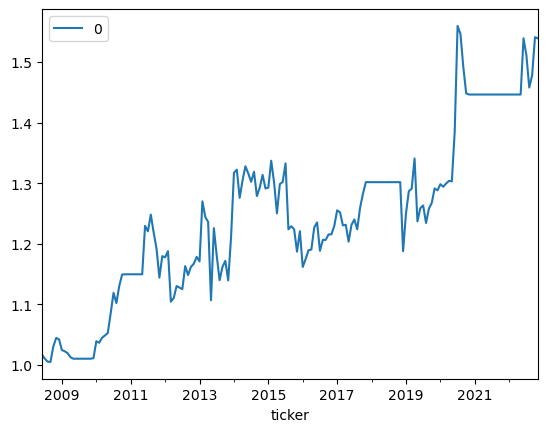

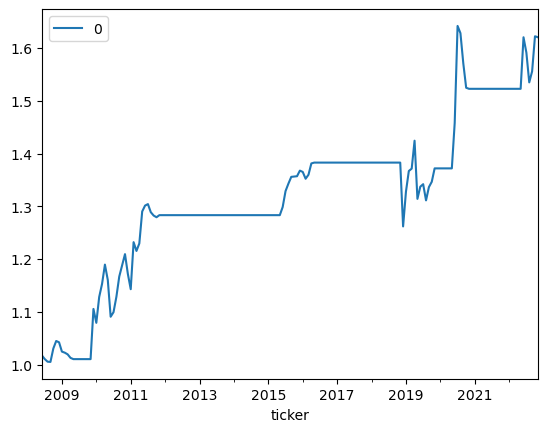

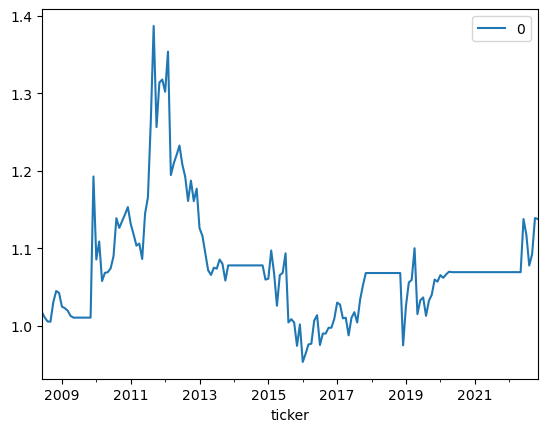

In [223]:
(experimental_results1['portfValue']/card_mvo[0].values).plot()
(experimental_results2['portfValue']/card_mvo[0].values).plot()
(experimental_results3['portfValue']/card_mvo[0].values).plot()
#CardMVO_results[('0.01', '0.75')][0].plot()

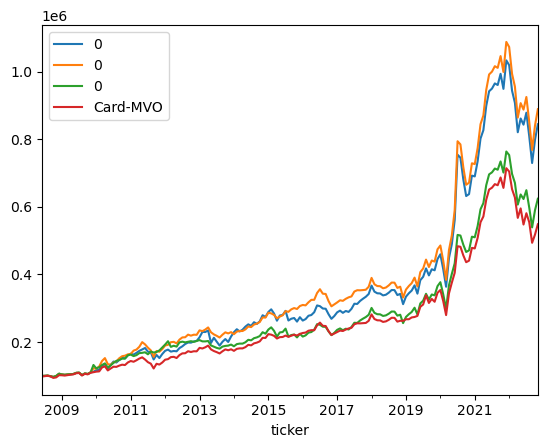

In [227]:
ax = plt.gca()
experimental_results1['portfValue'].plot(ax = ax, label = 'q = 1', legend = False)
experimental_results2['portfValue'].plot(ax = ax, label = 'q = 2', legend = False)
experimental_results3['portfValue'].plot(ax = ax, label = 'q = 3', legend = False)

card_mvo[0].plot(ax = ax, label = 'CardMVO', legend = False)
plt.legend()

In [209]:
def calculate_return_stats(portfValue, riskFree):
    portfRets = portfValue.pct_change(1).iloc[1:, :]
    # Calculate the portfolio excess returns
    portfExRets = portfRets.subtract(
        riskFree[(riskFree.index >= portfRets.index[0]) & (riskFree.index <= portfRets.index[-1])], axis=0)

    # Calculate the portfolio Sharpe ratio
    Ret = 12 * ((portfExRets + 1).apply(gmean, axis=0) - 1)
    Vol = (12 ** 0.5) * (portfExRets.std())
    SR = (12 ** 0.5) * (((portfExRets + 1).apply(gmean, axis=0) - 1) / portfExRets.std())
    Sortino = (12**0.5)*(((portfExRets + 1).apply(gmean, axis=0) - 1)/portfExRets.loc[portfExRets.values < 0].std())
    # Calculate the average turnover rate

    return Ret.iloc[0], Vol.iloc[0], SR.iloc[0]  , Sortino.iloc[0]

In [210]:
calculate_return_stats(experimental_results['portfValue'], riskFree)

(0.14749087410853523,
 0.19342845910515702,
 0.7625086545736897,
 1.271190355037457)

In [211]:
calculate_return_stats(card_mvo[0], riskFree)

(0.1148516912344002,
 0.16477159591457888,
 0.6970357396668159,
 1.044779304409962)